In [1]:
from diffusers import DDIMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt
from utils.test_utils import *
from PIL import Image
import torch
import os

model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"
save_location_prefix = "/data/local/weiyi"
save_location = "test"
save_location = os.path.join(save_location_prefix, save_location)
save_location

'/data/local/weiyi/test'

In [2]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [10]:
num_sample = 10
prompt = ["face of an smiling old man, best quality, photoshoot, Sharp and in focus, rich colors, 4k"] * num_sample
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 9  # Scale for classifier-free guidance
generator = torch.Generator(device=device).manual_seed(1234)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [11]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
# print(text_input)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [12]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [13]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=device,
)

In [14]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)
h_space_list = []

for idx, t in enumerate(tqdm(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        # noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        output = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)
        noise_pred = output.sample
        h_space_list.append(output.h_space)
        
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

h_space_list = torch.stack(h_space_list)
print(h_space_list.shape)
save_hspace(save_location, f"test1", h_space_list)

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([30, 20, 1280, 8, 8])


In [15]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    images = vae.decode(latents).sample

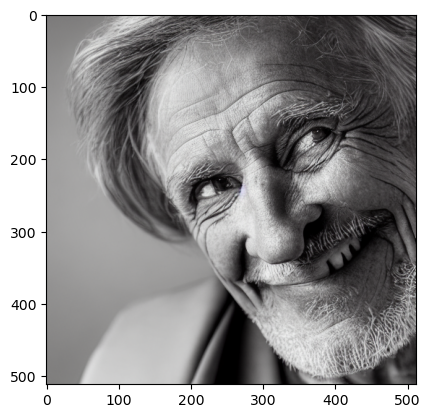

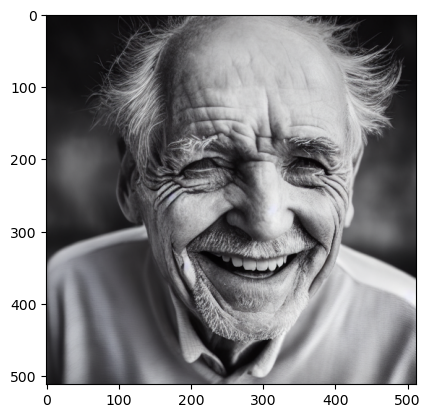

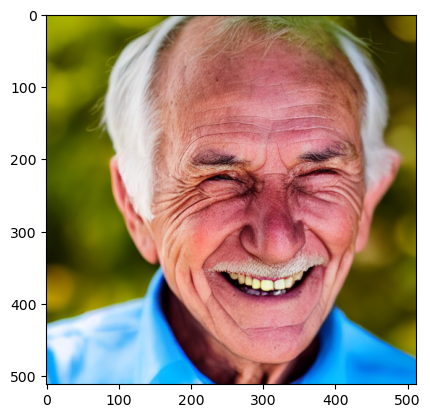

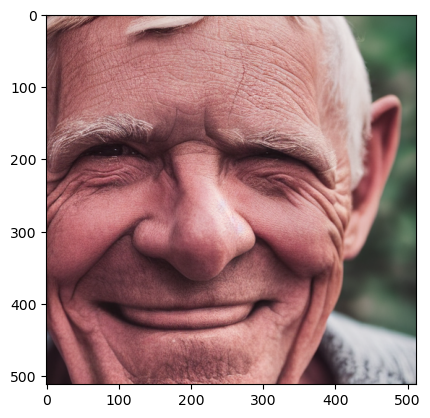

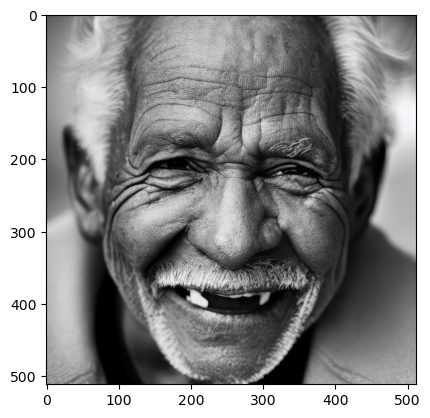

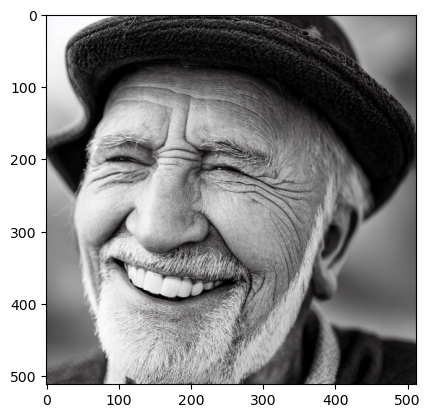

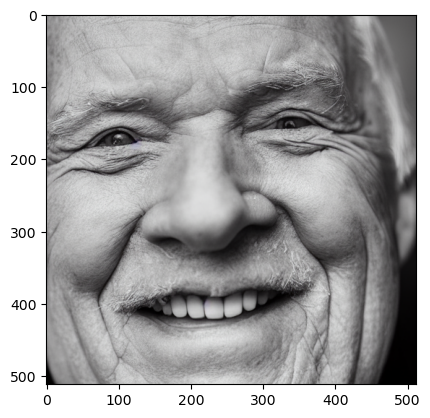

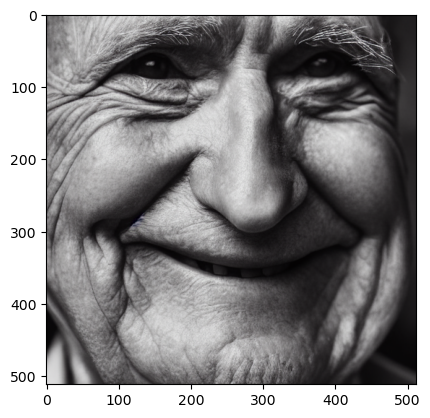

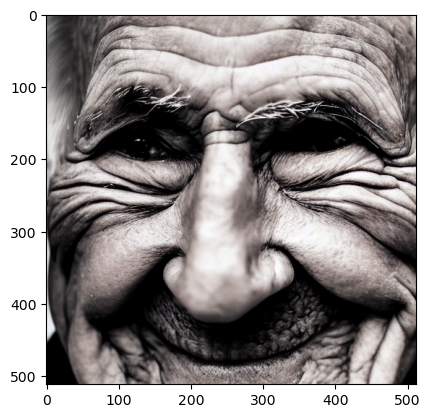

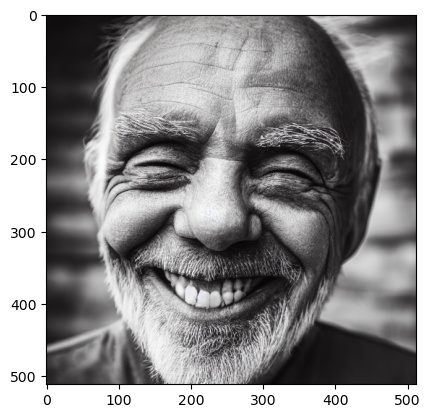

In [16]:
location = 'output/test1'
ensure_directory_exists(location)
offset = find_local_idx(location, 'png') + 1

for idx, img in enumerate(images):
    img = (img / 2 + 0.5).clamp(0, 1)
    img = (img.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    path = os.path.join(location, f"{(idx+offset):04d}.png")
    plt.imsave(path, img)
    plt.imshow(img)
    plt.show()